In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

log_dir = "logs/" + "dcgan_fashion_mnist/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(log_dir)

# tf.debugging.experimental.enable_dump_debug_info(log_dir, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)


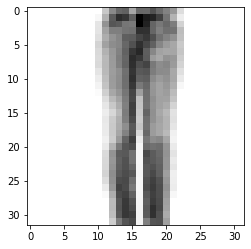

In [12]:
def convert_data_to_ds(images, labels):
#     print(images, labels)
    images = tf.cast(images, tf.float32)
    images = images / tf.reduce_max(images)
    images = tf.expand_dims(images, axis=-1)
    images = tf.image.resize(images, [32,32])
    return (images, labels)

train_data, valid_data = tf.keras.datasets.fashion_mnist.load_data()
# print("train_images:", train_data[0].shape)
# print("train_labels:", train_data[1].shape)

train_ds = tf.data.Dataset.from_tensor_slices(train_data).shuffle(1000).map(convert_data_to_ds).batch(16)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_data).shuffle(1000).map(convert_data_to_ds).batch(16)

plt.imshow(next(iter(valid_ds))[0][0,:,:,0], cmap="gray_r")

In [13]:
EPOCHS = 2
CHANNELS = 1
LATENT_DIMS = 100

In [14]:
def build_generator(latent_dims=100):
    inputs_latent = tf.keras.layers.Input(shape=[latent_dims])
    x = tf.keras.layers.Dense(8*8*128)(inputs_latent)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape(target_shape=[8,8,128])(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(4,4), strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=(4,4), strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(CHANNELS, kernel_size=(4,4), padding="same", activation="sigmoid")(x)
    
    generated_images=x
    model = tf.keras.models.Model(inputs=[inputs_latent], outputs=[generated_images])
    return model

generator_model = build_generator(LATENT_DIMS)
print("generator output shape:", generator_model(tf.random.uniform([100, LATENT_DIMS])).shape)
# tf.keras.utils.plot_model(generator_model, show_shapes=True)

generator output shape: (100, 32, 32, 1)


In [15]:
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=[32, 32, CHANNELS])
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding="same", activation="selu")(inputs)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="selu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="selu", name="conv128")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    
    classes = x
    model = tf.keras.models.Model(inputs=[inputs], outputs=[x])
    return model

disc_model = build_discriminator()
print("discriminator output shape:", disc_model(tf.random.uniform([100, 32, 32, CHANNELS])).shape)
# tf.keras.utils.plot_model(disc_model, show_shapes=True)

discriminator output shape: (100, 1)


In [16]:
generator_optimizer = tf.keras.optimizers.Adam()
disc_optimizer = tf.keras.optimizers.Adam()
xentropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [17]:
def Discriminator_Loss(real_inputs, generated_inputs):
    real_loss = xentropy_loss(tf.ones_like(real_inputs), real_inputs)
    generated_loss = xentropy_loss(tf.zeros_like(generated_inputs), generated_inputs)
    return real_loss + generated_loss

def Generator_Loss(generated_inputs):
    gen_loss = xentropy_loss(tf.ones_like(generated_inputs), generated_inputs)
    return gen_loss


In [18]:
@tf.function
def train_step(epoch, inputs):
    images, labels = inputs
    batch_size = tf.shape(images)[0]
    white_noise = tf.random.normal([batch_size, LATENT_DIMS])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model(white_noise, training=True)
        
        real_output = disc_model(images, training=True)
        fake_output = disc_model(generated_images, training=True)
        
        gen_loss = Generator_Loss(fake_output)
        disc_loss = Discriminator_Loss(real_output, fake_output)
        
    gen_gradients = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_gradients, generator_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

#     print("images:", images.shape)
#     print("generated_images:", generated_images.shape)

    with summary_writer.as_default():
        tf.summary.scalar("gen_loss", gen_loss, step=epoch)
        tf.summary.scalar("disc_loss", disc_loss, step=epoch)

    return gen_loss, disc_loss

In [19]:
# np.std(disc_model.get_layer("conv128").get_weights()[0])
pred = disc_model(tf.random.normal([10, 32,32, CHANNELS]))
xentropy_loss(tf.zeros_like(pred), pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7178626>

epoch  0
0 gen loss: 2.3709097 disc loss: 0.7969492
100 gen loss: 2.0540037 disc loss: 0.52508676
200 gen loss: 3.309911 disc loss: 0.56535053
300 gen loss: 2.2876096 disc loss: 0.5671947
400 gen loss: 2.6839685 disc loss: 0.9758123
500 gen loss: 1.9115204 disc loss: 1.0136371
600 gen loss: 1.598473 disc loss: 0.9397924
700 gen loss: 2.7721684 disc loss: 0.8411258
800 gen loss: 1.4480858 disc loss: 0.9805573
900 gen loss: 1.7521536 disc loss: 0.78881717
1000 gen loss: 2.4160967 disc loss: 0.885057
1100 gen loss: 2.2685757 disc loss: 1.2863169
1200 gen loss: 1.7790527 disc loss: 1.1264832
1300 gen loss: 2.3191557 disc loss: 0.8600746
1400 gen loss: 1.7363346 disc loss: 1.1719308
1500 gen loss: 1.5045035 disc loss: 1.0621123
1600 gen loss: 2.906849 disc loss: 0.9454709
1700 gen loss: 1.7112441 disc loss: 1.6676474
1800 gen loss: 2.098515 disc loss: 1.1775676
1900 gen loss: 2.9693007 disc loss: 0.65521306
2000 gen loss: 3.0559964 disc loss: 0.7094159
2100 gen loss: 2.1744776 disc loss: 1.

C:\Users\ikuchin\AppData\Local\Continuum\miniconda3\envs\tf23\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


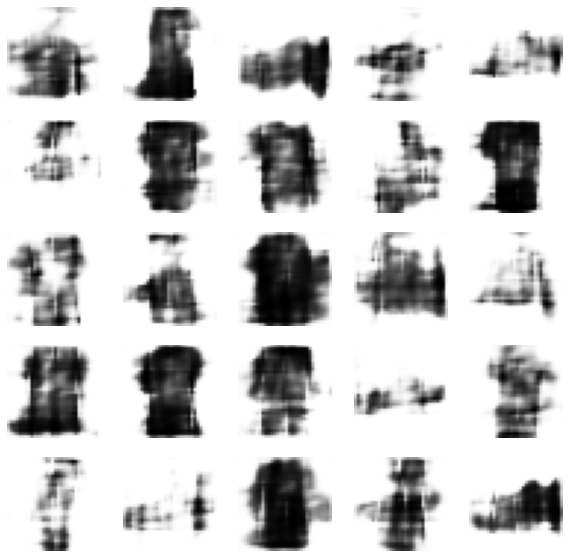

epoch  1
0 gen loss: 2.784389 disc loss: 1.1627277
100 gen loss: 3.0816128 disc loss: 0.5949201
200 gen loss: 3.09967 disc loss: 0.86959714
300 gen loss: 2.953977 disc loss: 0.945248
400 gen loss: 2.4000678 disc loss: 1.1195021
500 gen loss: 1.5997505 disc loss: 0.64241624
600 gen loss: 2.6498365 disc loss: 1.2584056
700 gen loss: 1.6252931 disc loss: 0.7539042
800 gen loss: 2.143405 disc loss: 0.807226
900 gen loss: 2.99426 disc loss: 0.9454266
1000 gen loss: 3.065422 disc loss: 1.2442961
1100 gen loss: 1.6904243 disc loss: 0.9923152
1200 gen loss: 3.2457561 disc loss: 1.3416941
1300 gen loss: 2.7674732 disc loss: 0.4428649
1400 gen loss: 2.3384218 disc loss: 0.66184926
1500 gen loss: 2.063879 disc loss: 1.1612184
1600 gen loss: 2.4633331 disc loss: 1.1107142
1700 gen loss: 2.24717 disc loss: 0.61535
1800 gen loss: 3.9950106 disc loss: 0.5366254
1900 gen loss: 1.7216629 disc loss: 0.9702395
2000 gen loss: 2.9929545 disc loss: 0.38079008
2100 gen loss: 2.244631 disc loss: 1.3350062
220

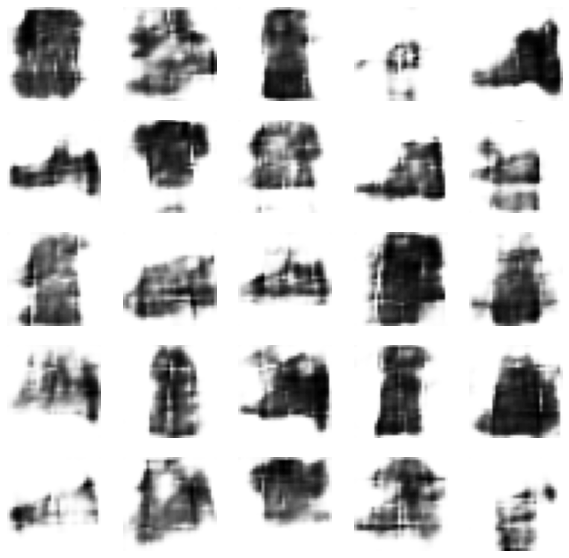

In [22]:
def draw_progress_pictures():
    NUMBER_OF_PICTURE_TO_DRAW = 25
    NUMBER_OF_ROWS = tf.cast(tf.sqrt(NUMBER_OF_PICTURE_TO_DRAW + 0.00001), tf.float16).numpy()
#     print(NUMBER_OF_ROWS)
    white_noise = tf.random.normal([NUMBER_OF_PICTURE_TO_DRAW, LATENT_DIMS])
    generated_images = generator_model(white_noise)
    
    plt.figure(figsize=(10, 10))
    for i in range(NUMBER_OF_PICTURE_TO_DRAW):
        plt.subplot(NUMBER_OF_ROWS, NUMBER_OF_ROWS, i + 1)
        plt.axis(False)
        plt.imshow(generated_images[i], cmap="gray_r")

for epoch in range(EPOCHS):
    print("epoch ", epoch)
    for idx, inputs in enumerate(train_ds):
        gen_loss, disc_loss = train_step(epoch, inputs)
        if(idx%100==0):
            print(idx, "gen loss:", gen_loss.numpy(), "disc loss:", disc_loss.numpy())
    print()
    
    draw_progress_pictures()
    plt.show()

In [ ]:
generator_model.trainable_variables[0]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np

x = np.array([-2.2, -1.4, -.8, .2, .4, .8, 1.2, 2.2, 2.9, 4.6])
y = np.array([0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

logr = LogisticRegression(solver='lbfgs')
logr.fit(x.reshape(-1, 1), y)

y_pred = logr.predict_proba(x.reshape(-1, 1))[:, 1].ravel()
loss = log_loss(y, y_pred)

print('x = {}'.format(x))
print('y = {}'.format(y))
print('p(y) = {}'.format(np.round(y_pred, 2)))
print('Log Loss / Cross Entropy = {:.4f}'.format(loss))

In [24]:
tf.losses.BinaryCrossentropy(from_logits=False)([0.], [0.])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0>

In [ ]:
log_loss([0., 1.], [0.5, 0.5])